In [27]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [28]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.path.join(os.getenv("OUTPUTS_PATH"), "robustness_checks", "rb2")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [29]:
df = pd.read_pickle(os.path.join(DATA_PATH, "us_fed_speeches.pickle"))
FILES_PREFIX = "us_speeches"

In [30]:
# breakpoint = pd.to_datetime("2007-05-01")

# df["label"] = 1.0
# df.loc[df["date"] <= breakpoint, "label"] = 0

In [31]:
df

,date,text,label
0,2004-01-03,Ben S Bernanke: Fedspeak\nSpeech by Mr Ben S B...,0.0
1,2004-01-03,Ben S Bernanke: Conducting monetary policy at ...,0.0
2,2004-01-03,Alan Greenspan: Risk and uncertainty in moneta...,0.0
3,2004-01-04,Ben S Bernanke: Monetary policy and the econom...,0.0
4,2004-01-04,"Roger W Ferguson, Jr: Lessons from past produc...",0.0
...,...,...,...
595,2010-03-25,Ben S Bernanke: Federal Reserve's exit strateg...,1.0
596,2010-03-26,Daniel K Tarullo: Lessons from the crisis stre...,1.0
597,2010-03-26,Kevin Warsh: An ode to independence\nSpeech by...,1.0
598,2010-03-26,Brian P Sack: Dollar asset markets - prospects...,1.0


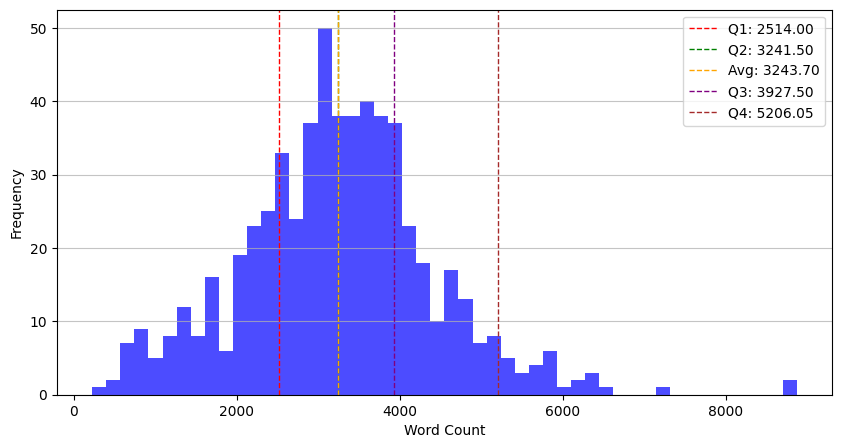

In [32]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Pre-processing data

##### 1. Data cleaning

In [33]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/us_speeches_texts.pickle
Loaded 600 texts


##### 2. Embedding texts

In [34]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/us_speeches_embeddings.pickle
Loaded 600 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [35]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_finbert.pickle
Loaded 600 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [36]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments_distilbert.pickle
Loaded 600 sentiments


# TOPOL Modeling

### Prepare data

In [37]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

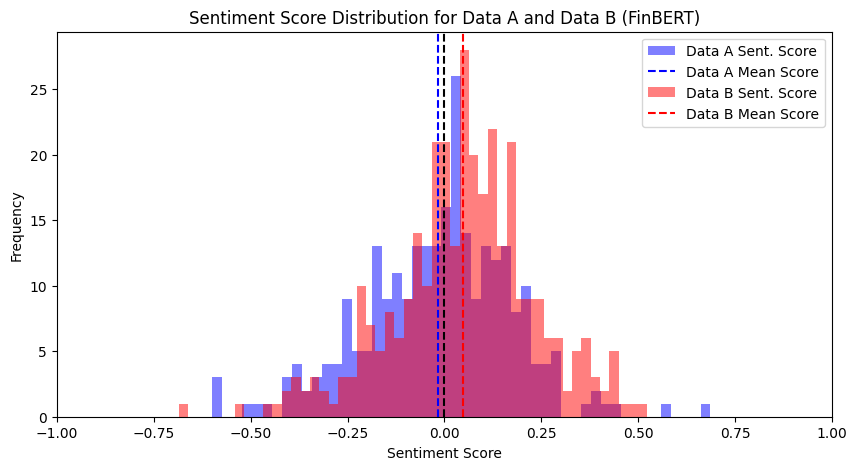

In [38]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_finbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_finbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_finbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (FinBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_finbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

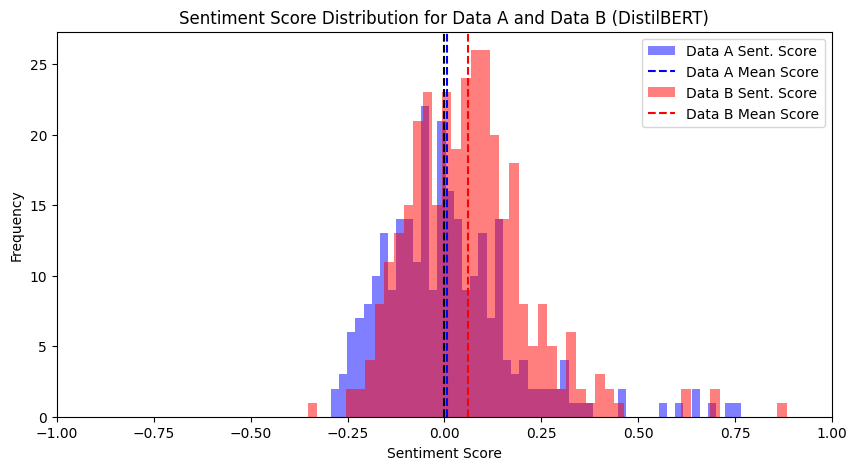

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score_distilbert"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score_distilbert"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score_distilbert"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.title('Sentiment Score Distribution for Data A and Data B (DistilBERT)')
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_distilbert_histogram.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [40]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 1.0, # Change that concerns the robustness check: decreasing the resolution parameter
    # 'resolution': 1.5, --- IGNORE ---
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=50,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=False,
)

### TOPOL modeling analysis

In [41]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [42]:
topol_model.dataset_A.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,89,"{'date': 4966, 'num': 3059, 'inflation': 2443,...","[-0.0020574310453074954, 0.009144447790655003,...","[-0.6503314651768612, -8.084677005082034]",[Ben S Bernanke: The economy and financial mar...,"{'date': 0.4885681977490842, 'financial': 0.27..."
1,1,74,"{'financial': 2848, 'risk': 1664, 'date': 1488...","[0.005958897804776899, 0.017014694047739375, 0...","[-0.13730387380850073, -4.968536937558973]",[Ben S Bernanke: Financial regulation and supe...,"{'financial': 0.502007684259503, 'federal': 0...."
2,2,52,"{'date': 1802, 'num': 1181, 'credit': 1107, 'm...","[0.014643761123387286, 0.03054088032625329, 0....","[1.3796830673057299, -6.519824954179617]",[Ben S Bernanke: Subprime mortgage lending and...,"{'date': 0.47056379555401345, 'mortgage': 0.26..."
3,3,52,"{'federal': 1473, 'date': 1448, 'financial': 1...","[-0.002847577167603259, 0.001984433563148531, ...","[-0.946103852098951, -6.286780137282151]",[Ben S Bernanke: Federal Reserve programs to s...,"{'financial': 0.3446969167284993, 'federal': 0..."


In [43]:
topol_model.dataset_B.cluster_info

,Cluster,Count,Top_Words,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,187,"{'date': 9355, 'num': 4980, 'inflation': 3259,...","[0.008526781387440362, 0.012481623231789543, 0...","[-0.45370756195768475, -8.89725195532814]",[Donald L Kohn: Monetary policy in a time of m...,"{'date': 0.6016010793410088, 'num': 0.27335719..."
1,1,96,"{'risk': 3331, 'date': 2280, 'financial': 2209...","[0.014401040714574265, 0.02045064414657342, 0....","[-0.28012534106771153, -4.280205773810546]",[Susan Schmidt Bies: A US supervisor's perspec...,"{'risk': 0.4348030211307566, 'basel': 0.315773..."
2,2,27,"{'date': 962, 'credit': 601, 'num': 598, 'risk...","[0.0268279489353989, 0.02011510924313808, 0.07...","[1.2983725622848228, -6.816114178410283]",[Ben S Bernanke: Community development financi...,"{'date': 0.3692035442465557, 'num': 0.21737131..."
3,3,23,"{'reserve': 671, 'date': 670, 'federal': 490, ...","[9.511157100939232e-05, -0.0001636023526257106...","[-1.961009927417921, -6.272081520246423]",[Susan Schmidt Bies: The Federal Reserve Syste...,"{'reserve': 0.38680554379189025, 'date': 0.341..."


Drift computed successfully, ready to vizualize.


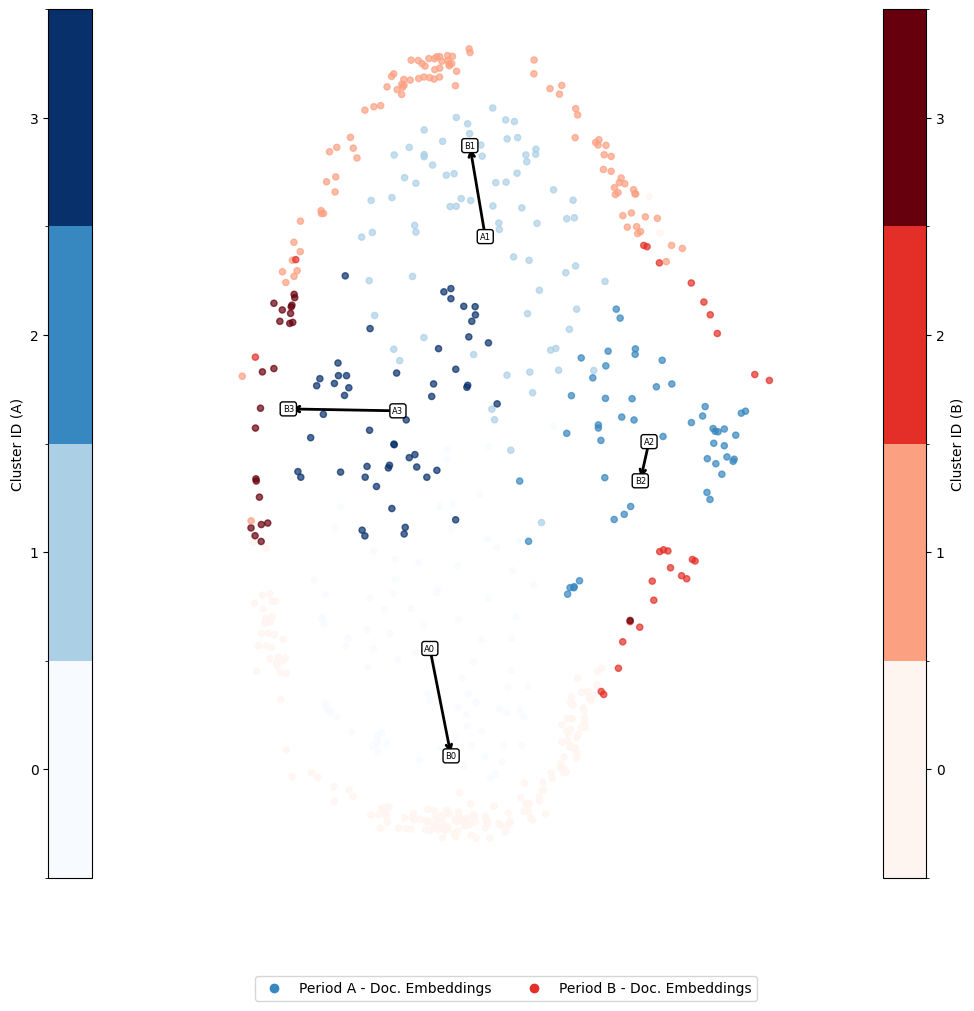

In [44]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [45]:
no_nan_drifts = { k: v for k, v in topol_model.drifts.items() if isinstance(v, np.ndarray) }
drifts_df = pd.DataFrame.from_dict(no_nan_drifts, orient='index', columns=['x', 'y'])
# drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

In [46]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

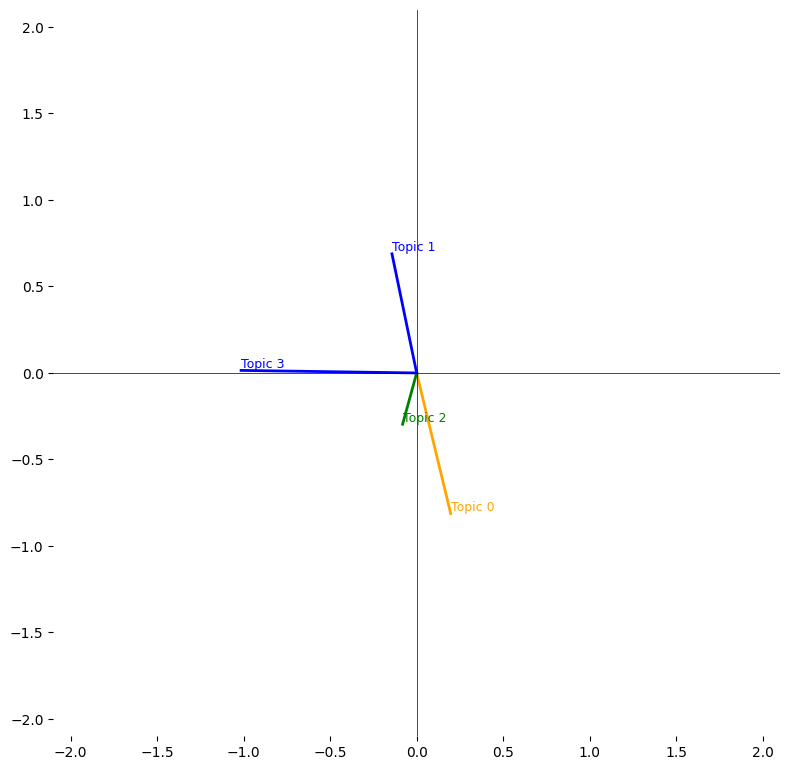

In [47]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [48]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [49]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [50]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [51]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [52]:
zipped_representative_docs = list(zip(
    topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
    topol_model.dataset_B.cluster_info['Top_Representative_Docs']
))
top_n_docs = 3  # Number of top documents to compare per cluster

for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

    # Get the representative documents for each cluster
    if top_n_docs is not None:
        text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
        text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
    else:
        text1 = from_list_to_string(top_docs_A)
        text2 = from_list_to_string(top_docs_B)

    # Generate the prompt for the LLM
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, max_tokens=1000000)

    # Dynamic response variable (you can also use a list or dict instead of naming each one)
    var_name = f"response_row{i}"
    globals()[var_name] = response

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

    print(f"✅ Processed and saved row {i}")

  0%|          | 0/4 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Economic Growth – Economic Decline",
    "polar_extremes_subtitle": "Economic decline – Economic growth",
    "presence": "both",
    "coverage_text1": 60,
    "coverage_text2": 60,
    "difference_confidence": 10,
    "cosine_similarity": 0.85,
    "text1_evidence_sentences": [
      "In part as the result of the developments in financial markets, the outlook for the economy has worsened in DATE, and the downside risks to growth have increased.",
      "More-expensive and less-available credit seems likely to continue to be a source of restraint on economic growth.",
      "At present, my baseline outlook involves a period of sluggish growth, followed by a somewhat stronger pace of growth starting later DATE as the effects of monetary and fiscal stimulus begin to be felt."
    ],
    "text2_evidence_sentences": [
      "All told, the U.S. economy has apparently made the transition from weakness to solid growth.",
      "Real gross domest